In [1]:
## Receive the signal
include("rxsignal_withchannelandfreqoff.jl");

In [2]:
## Load the template signal
include("pss2.jl");

In [3]:
using FFTW

In [4]:
## Load the useful math operations
include("operations.jl");

In [5]:
## Assign the received signal a variable Ŝᵣₓ³
𝑅ₚₛₛ³ = rxs3; # RX Received Signal 3 File Handle
@show size(𝑅ₚₛₛ³); 

size(𝑅ₚₛₛ³) = (616447, 1)


In [6]:
using LinearAlgebra

In [7]:
## Assign the template signal a variable 𝐻ₚₛₛ²
## convert the signal in time domain
Pₚₛₛ² = pss_2; # File Handle
Hₚₛₛ²ᵀ = transpose.(Pₚₛₛ²); # Hessian Transpose ?
𝐻ₚₛₛ² = Fᴵ(Hₚₛₛ²ᵀ); # S Slanted (fourier transform) in time domain
𝐻ₚₛₛ² ./= norm(𝐻ₚₛₛ²);
𝐻ₚₛₛ² = 𝐻ₚₛₛ²[(end-143):end] ⧺ 𝐻ₚₛₛ² ; @show size(𝐻ₚₛₛ²); # end is 2048 in this case, concat math 

size(𝐻ₚₛₛ²) = (2192,)


In [8]:
## Prepare the template signal for convolution
𝐻̅ₚₛₛ² = ⦰(𝐻ₚₛₛ²); # reverse #typed H\overbar
𝐻̅ₚₛₛ²ᴴ = conj(𝐻̅ₚₛₛ²); # conjugate 

In [9]:
using DSP

In [10]:
## Perform the convolution between the 2 signals
𝐻̂ₚₛₛ² = 10 * log10.(abs.( 𝑅ₚₛₛ³ ⊗ 𝐻̅ₚₛₛ²ᴴ )); @show size( 𝐻̂ₚₛₛ² );  #typed \itH\hat

size(𝐻̂ₚₛₛ²) = (618638, 1)


In [11]:
# Find maximum value and its index
Ĉᵩ², 𝑁̂𝑓² = argmax(𝐻̂ₚₛₛ²); @show Ĉᵩ², 𝑁̂𝑓²;

(Ĉᵩ², 𝑁̂𝑓²) = (50.649042476081405, CartesianIndex(6628, 1))


In [12]:
θ₁ = 144
θ₂ = 2048
getindex(𝑁̂𝑓², 1) - ( θ₂ + θ₁ )

4436

In [13]:
using Plots

In [14]:
# Plot the result
m2_chan_plot = plot(𝐻̂ₚₛₛ², xlabel="Sample", ylabel="Power (dB)", title="Convolution Result", ylim=(-20, 60))
savefig(m2_chan_plot,"images/m2_chan_plot.png");

<img src=images/m2_chan_plot.png width='' heigth='' > </img>

In [15]:
########################################################
# Frequency Offset Estimator Function
########################################################
function freq_offset_est(𝑅ₚₛₛ, 𝐻ₚₛₛ, Nf, m, 𝑓ₛ)

    # Frequency offset estimator
    Y = zeros(ComplexF64, length(m));
    L = length(𝐻ₚₛₛ)
    t = 0:(1/𝑓ₛ):((L-1)/𝑓ₛ)

    signal_part = 𝑅ₚₛₛ[Nf:(Nf + L -1)]; @show size( signal_part )
    for j = 1:length(m)
        Y[j] = Y[j] + abs.(∑(exp.(-2*pi*im*m[j].*t) .* conj(𝐻ₚₛₛ) .* ⦰(signal_part)))^2;
    end

    return Y
end

freq_offset_est (generic function with 1 method)

In [16]:
𝑓ₛ = 61.44e6 # Msamples/s.

Δ𝑓 = 10.0
m = -7500.:Δ𝑓:7500.

N𝑓 = getindex(𝑁̂𝑓², 1) - length(𝐻ₚₛₛ²) + 1; @show N𝑓;

N𝑓 = 4437


In [17]:
# Grab the function Profs Frequency Offset with his values
Y = freq_offset_est(𝑅ₚₛₛ³, 𝐻ₚₛₛ², N𝑓, m, 𝑓ₛ); # @show Y

size(signal_part) = (2192,)


In [18]:
N̂𝑓, m̂ = argmax(abs.(Y)); 
@show (10 * log10(N̂𝑓));
@show (m̂);

10 * log10(N̂𝑓) = 88.46888484427753
m̂ = 587


In [19]:
cfo_estim_plot = 
plot(10 * log10.(abs.(Y)), xlabel="Sample", ylabel="Power (dB)", title="Estimation Result")
scatter!((m̂, (10 * log10(N̂𝑓))), color="red", label="m̂")
savefig(cfo_estim_plot,"images/cfo_estim_plot.png");

<img src=images/cfo_estim_plot.png width='' height='' > </img>

In [26]:
# Compensate CFO by multiplying the received signal with a complex exponential
function compensate_cfo(𝑅ₚₛₛ, N̂𝑓, 𝑓ₛ, Npss)
    # Generate a complex exponential with the specified frequency offset
    𝑅ₚₛₛ = 𝑅ₚₛₛ .* exp.(-2π * im * collect(1:4*Npss) * (N̂𝑓/𝑓ₛ))
    return 𝑅ₚₛₛ
end

compensate_cfo (generic function with 1 method)

In [27]:
(m̂+512)-m̂
Npss = θ₂ + θ₁

2192

In [28]:
𝑅̅ₚₛₛ = 𝑅ₚₛₛ³[N𝑓:(N𝑓+θ₂)-1]; @show m̂, size(𝑅̅ₚₛₛ);

(m̂, size(𝑅̅ₚₛₛ)) = (587, (2048,))


In [29]:
Tu = 512 # Unit of samples
Ncp = div(144, 4)

36

In [30]:
Y = compensate_cfo(𝑅̅ₚₛₛ, N̂𝑓, 𝑓ₛ, Tu);

## PSS demodulation

In [31]:
using FFTW, DSP

In [32]:
# Start demodulation 
𝐹ₓ = DSP.fftshift(DSP.fft(Y)); @show size(𝐹ₓ), 𝐹ₓ[1];
# Correct for the fact that we're starting the demodulation at the middle of the cyclic prefix
# 𝐹ₓ .*= exp.(1im * 2π .* DSP.fftshift(DSP.fftfreq(Tu)) * Ncp / 2); 

(size(𝐹ₓ), 𝐹ₓ[1]) = ((2048,), -410.7604785466938 + 13893.469640810601im)


In [56]:
# The PSS ocuppies subcarriers 56 to 128 relative to the start of an SS/PBCH block
# In this case, the SS/PBCH block starts at subcarrier -120 (with respect to the
# subcarrier we have decided to treat as DC). This means that the SS/PBCH block is
# not centred with respect to this choice of DC (but this doesn't matter).
pss_sc_sel = range(144, 127+143)

144:270

In [57]:
x_all_sc = collect(0:size(𝐹ₓ,1)); y_all_sc = 10 * log10.(abs2.(𝐹ₓ));

In [58]:
x_pss_sc = collect(0:size(𝐹ₓ,1))[pss_sc_sel]; y_pss_sc = 10 * log10.(abs2.(𝐹ₓ[pss_sc_sel]));

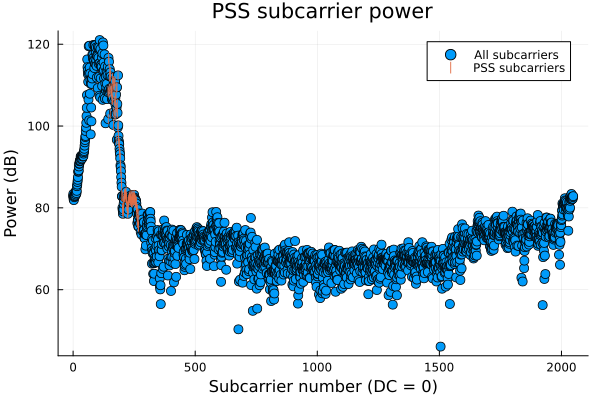

In [59]:
# all_sb_plot = 
scatter(x_all_sc, y_all_sc
    , label="All subcarriers"
    , markersize=5
)
scatter!(x_pss_sc, y_pss_sc
    , label="PSS subcarriers"
    , markershape=:vline
    , markersize=5
)

title!("PSS subcarrier power")
xlabel!("Subcarrier number (DC = 0)")
ylabel!("Power (dB)")

# savefig(all_sb_plot,"images/all_sb_plot.png");

In [60]:
function plot_ref(ref; ax=nothing, refscale=1)
    const_dict = Dict(
    "bpsk" => [-1, 1],
    "pilot" => [1],
    "qpsk" => [exp(1.0im * (π/2 * k + π/4)) for k in 0:3]
    )

    constant = get(const_dict, ref, nothing) * refscale
    ax = ax isa Nothing ? plt : ax
    scatter!(ax, real(constant), imag(constant), color=:red, markersize=3)
end

function constellation_plot(z::Vector{ComplexF64}; title=nothing, ref="bpsk", ax=nothing, refscale=1, kwargs...)
    ax = ax isa Nothing ? plot(size=(300, 300)) : ax
    scatter!(ax, real(z), imag(z), kwargs...)
    plot_ref(ref, ax=ax, refscale=refscale)
    plot!(ax, aspect_ratio=:equal, xlims=(-1.5, 1.5), ylims=(-1.5, 1.5), xticks=[], yticks=[])
    # title && title!(ax, title)
    if title !== nothing
        title!(ax, title)
    end
end

constellation_plot (generic function with 1 method)

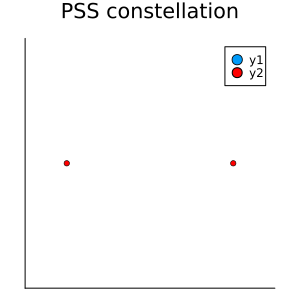

In [61]:
pss_sym_demod = 𝐹ₓ[pss_sc_sel];
constellation_plot(pss_sym_demod, title="PSS constellation")

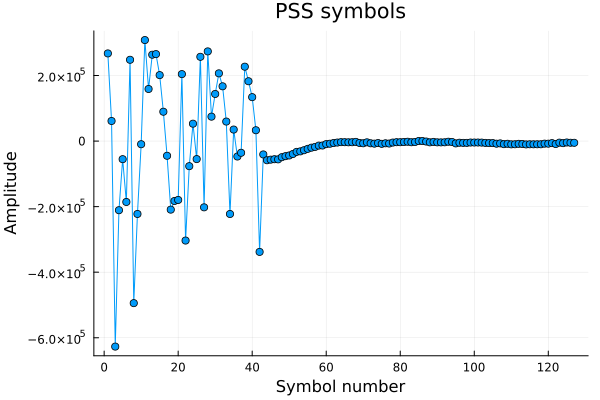

In [62]:
plot(real(pss_sym_demod), marker=:circle, label="")
title!("PSS symbols")
xlabel!("Symbol number")
ylabel!("Amplitude")

In [63]:
function pss_sequence(nid2)
    x = zeros(UInt8, 127)
    x[1:7] .= [1, 1, 1, 0, 1, 1, 0][end:-1:1]

    for j in 8:127
        x[j] = x[j - 3] ^ x[j - 6]
    end

    indices = x[(collect(1:127) .+ 43 * nid2) .% 127 .+ 1]
    return 1.0 .- 2.0 .* float.(indices)
end

pss_sequence (generic function with 1 method)

In [64]:
@show size(pss_sym_demod)

size(pss_sym_demod) = (127,)


(127,)

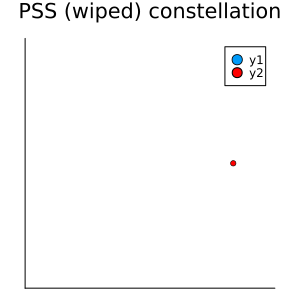

In [65]:
pss_sym_demod_wipe = float(pss_sym_demod) .* pss_sequence(1);
constellation_plot(pss_sym_demod_wipe, title="PSS (wiped) constellation", ref="pilot")